In [1]:


#Get the path of the current working directory
import os
cwd = os.getcwd()
print(cwd)



/Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE


In [2]:


# th = time_horizon.get_model_time_horizon()
#print(th)
# print(time_horizon.data_time_horizon)  
# Pass the time_horizon object to other parts of the model

[2015 2020 2025 2030 2035 2040 2045 2050 2055 2060 2065 2070 2075 2080
 2085 2090 2095 2100 2105 2110 2115 2120 2125 2130 2135 2140 2145 2150
 2155 2160 2165 2170 2175 2180 2185 2190 2195 2200 2205 2210 2215 2220
 2225 2230 2235 2240 2245 2250 2255 2260 2265 2270 2275 2280 2285 2290
 2295 2300]


In [2]:
path_to_justice = '/Users/palokbiswas/Desktop/pollockdevis_git/JUSTICE'

# import sys
# sys.path.insert(0, path_to_justice)



from src.economy.neoclassical import NeoclassicalEconomyModel
from src.emissions.emission import OutputToEmissions
#from economy.neoclassical import NeoclassicalEconomyModel
from src.data_loader import DataLoader
from src.enumerations import *
from src.model_time import TimeHorizon
# Instantiate the data loader

# Load the data
data_loader = DataLoader()


# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

In [3]:

from src.climate.coupled_fair import CoupledFAIR
from src.enumerations import *
scenario = SSP.SSP1
fair_scenario = [(ssp_to_rcp[scenario]).value]

model = CoupledFAIR()


model.fair_justice_run_init(time_horizon=time_horizon, scenarios=fair_scenario)



In [4]:
no_of_ensembles = model.__getattribute__('number_of_ensembles')
print(no_of_ensembles)
model = NeoclassicalEconomyModel(input_dataset = data_loader, time_horizon=time_horizon, climate_ensembles=1001)
emissions = OutputToEmissions(input_dataset=data_loader, time_horizon=time_horizon, climate_ensembles=1001)

1001


In [ ]:
gdp = NeoclassicalEconomyModel.__getattribute__(model, 'gdp_dict')
#gdp = data_loader.GDP_DICT
testdf = gdp['SSP1']

population = NeoclassicalEconomyModel.__getattribute__(model, 'population_dict')
testdf2 = population['SSP1']

In [ ]:
print(model.__getattribute__('capital_elasticity_in_production_function'))

In [ ]:
print(model.__getattribute__('depreciation_rate_capital'))

In [ ]:
print(model.get_optimal_long_run_savings_rate())

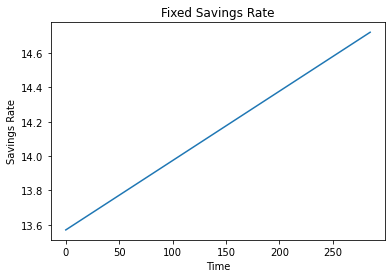

In [5]:
import numpy as np
#Create a fixed savings rate
fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
#fixed_savings_rate Validated with RICE50 for timestep 1 and 5

set_year = time_horizon.model_time_horizon


for i, years in enumerate(set_year):
    
    t = i+1 #index starts at 0, so add 1 to get the year

    if t != 1: # no need to repeat for the first year

        next_rate = data_loader.SAVING_RATE_INIT_ARRAY + (model.get_optimal_long_run_savings_rate() - data_loader.SAVING_RATE_INIT_ARRAY)*((t - 1)/(len(set_year) - 1))
        # append to the fixed savings rate array for each year
        fixed_savings_rate = np.column_stack((fixed_savings_rate, next_rate))

from matplotlib import pyplot as plt
plt.plot(np.sum(fixed_savings_rate, axis=0))
plt.title("Fixed Savings Rate")
plt.xlabel("Time")
plt.ylabel("Savings Rate")
plt.show()

In [ ]:
len(set_year)

In [6]:
scenario = 0 #SSP.SSP1
#print(scenario.value)

for i in range(len(set_year)):
    output = model.run(scenario = scenario, timestep=i, savings_rate=fixed_savings_rate[:, i])
    #print shape of output
    # print(output.shape)
    # print(i)
    #should emissions be an array of shape region, timesteps?
    emis = emissions.run_emissions(timestep=i, scenario=scenario, output=output[:,i,:], emission_control_rate=0.0)


#run_emissions(self, timestep, scenario, output, emission_control_rate)

In [ ]:
print(output)

In [8]:
import pandas as pd
testdf = pd.DataFrame(output[:,:,500])

In [9]:
test_ems = pd.DataFrame(emis[:,0,:])

In [ ]:
import pandas as pd
testdf = pd.DataFrame(output)

In [1]:
from src.model_time import TimeHorizon
# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

# th = time_horizon.get_model_time_horizon()
#print(th)
# print(time_horizon.data_time_horizon)  

from src.climate.coupled_fair import CoupledFAIR




model = CoupledFAIR()

#model.fair_justice_run_init(time_horizon=time_horizon, scenarios=["ssp245"])

In [2]:
# # model.fair_fill_data(time_horizon=time_horizon, scenarios=["ssp245"])
# # model.test_init_fair(scenarios=["ssp245"], time_horizon=time_horizon)
# model.species_configs
# model.configs
from src.enumerations import *
scenario = SSP.SSP1
fair_scenario = [(ssp_to_rcp[scenario]).value]

model.fair_justice_run_init(time_horizon=time_horizon, scenarios=fair_scenario)

print(fair_scenario)

['ssp119']


In [4]:
# time_horizon.start_year - 1750

print(model.__getattribute__('number_of_ensembles'))

1001


In [4]:
#create a list of years 1750 to 2014 with 1 year timestep
#0 -> 1750
#265 -> 2015
#549 -> 2299
#FAIR takes up until 549 
#FAIR outputs t+1 for input of t

import time
import numpy as np
# justice_run_years = np.arange(
#     self.start_year_justice,
#     (self.end_year_fair + self.timestep_justice),
#     self.timestep_justice,
# )
justice_run_years = np.arange( #This generates till 2300
    2015,
    (2300 + 1),
    1,
)

#Loop through the number of years starting with zero for 1750
#0
#Need to do this prerun in the init
#Then figure out how to clear emissions and refill with new emissions



In [4]:
temperature = model.get_temperature_array()

temp = temperature[:,0,:,0]

In [6]:
loop_counter =  model.__getattribute__("fair_historical_timestep_run_count")
print(loop_counter)

265


In [7]:
len(justice_run_years)


286

In [7]:
for i in range(loop_counter, (((len(justice_run_years))+loop_counter)-1)):
    #print(i)
    model.stepwise_run(i)

In [11]:
"""
#This is for FAIR #Loop should run till (len(justice_run_years) -1 )
for i in range(loop_counter, (len(justice_run_years) - 1 )): # This works. The justice loop should run from loop counter and end with the last year of the justice run
    print(i , justice_run_years[i])
    # print(i)
    # start_time = time.time()
    model.stepwise_run(i)
    # end_time = time.time()  # palok
    # elapsed_time = end_time - start_time  # calculate the difference
    # f.calculate_toa_ocean_airborne_fraction()
    # f.prepare_output_xarrays()


"""

'\n#This is for FAIR #Loop should run till (len(justice_run_years) -1 )\nfor i in range(loop_counter, (len(justice_run_years) - 1 )): # This works. The justice loop should run from loop counter and end with the last year of the justice run\n    print(i , justice_run_years[i])\n    # print(i)\n    # start_time = time.time()\n    model.stepwise_run(i)\n    # end_time = time.time()  # palok\n    # elapsed_time = end_time - start_time  # calculate the difference\n    # f.calculate_toa_ocean_airborne_fraction()\n    # f.prepare_output_xarrays()\n\n\n'

In [13]:
temperature = model.get_temperature_array()

temp = temperature[:,0,:,0]

AttributeError: 'NeoclassicalEconomyModel' object has no attribute 'get_temperature_array'

In [5]:
#Shape: timepoints, scenarios and ensemblemodels
current_emissions = model.emissions.sel(specie="CO2 FFI", scenario=fair_scenario)
#Plots the current emissions
current_emissions = current_emissions[:,0,:]

In [ ]:
# #create a list of years 1750 to 2014 with 1 year timestep
# import time
# import numpy as np



# #Loop through the number of years starting with zero for 1750
# loop_counter = 0
# #Need to do this prerun in the init
# #Then figure out how to clear emissions and refill with new emissions
# for i in range(0, len(years_fair)): #This should be 1 for justice (i think)
#     loop_counter = i
    
#     start_time = time.time()
#     model.stepwise_run(i)
#     end_time = time.time()  # palok
#     elapsed_time = end_time - start_time  # calculate the difference
#     # f.calculate_toa_ocean_airborne_fraction()
#     # f.prepare_output_xarrays()
#     #print(f"One iteration {i} of the loop took {elapsed_time} seconds to run.")

#Purging code
"""
        # Purge the emissions data filled from RCMIP database from 2015 onwards. This will be filled by JUSTICE Economy submodel
        # ("timepoints", "scenario", "config", "specie")

        # Select data for "CO2 FFI" and scenario
        rcmip_emission_array = self.emissions.sel(specie="CO2 FFI", scenario=scenarios)
        # Calculate justice start index
        justice_start_index = self.start_year_justice - self.start_year_fair
        # Create array with rcmip emissions before justice_start_index and zeros after
        emissions_purge_array = np.concatenate(
            [
                rcmip_emission_array[0:justice_start_index].values,
                np.full(
                    (self.end_year_fair - self.start_year_justice,)
                    + rcmip_emission_array.shape[1:],
                    np.nan,
                ),
            ],
            axis=0,
        )

        fill(self.emissions, emissions_purge_array, specie="CO2 FFI")
"""

In [5]:
# temperature = model.get_temperature_array()

# temp = temperature[:,0,:,0]

# NEW EXPERIMENTS OF INTEGRATION

In [1]:
from src.economy.neoclassical import NeoclassicalEconomyModel
from src.emissions.emission import OutputToEmissions
#from economy.neoclassical import NeoclassicalEconomyModel
from src.data_loader import DataLoader
from src.enumerations import *
from src.model_time import TimeHorizon
from src.climate.temperature_downscaler import TemperatureDownscaler
# Instantiate the data loader
from src.climate.coupled_fair import CoupledFAIR
from src.enumerations import *
import pandas as pd
import numpy as np
from src.damage.kalkuhl import DamageKalkuhl




In [2]:
scenario = SSP.SSP1
fair_scenario = [(ssp_to_rcp[scenario]).value]



# Load the data
data_loader = DataLoader()


# Instantiate the TimeHorizon class
time_horizon = TimeHorizon(start_year=2015, end_year=2300, data_timestep=5, timestep=1)

model = CoupledFAIR()
downscaler = TemperatureDownscaler(input_dataset = data_loader)

model.fair_justice_run_init(time_horizon=time_horizon, scenarios=fair_scenario)

damage_function = DamageKalkuhl(input_dataset=data_loader, time_horizon=time_horizon, climate_model=model)

In [3]:
no_of_ensembles = model.__getattribute__('number_of_ensembles')
print(no_of_ensembles)
economy = NeoclassicalEconomyModel(input_dataset = data_loader, time_horizon=time_horizon, climate_ensembles=no_of_ensembles)
emissions = OutputToEmissions(input_dataset=data_loader, time_horizon=time_horizon, climate_ensembles=no_of_ensembles)


1001


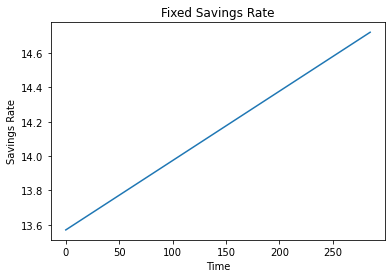

In [4]:

#Create a fixed savings rate
fixed_savings_rate = np.copy(data_loader.SAVING_RATE_INIT_ARRAY).reshape(-1, 1)
#fixed_savings_rate Validated with RICE50 for timestep 1 and 5

set_year = time_horizon.model_time_horizon


for i, years in enumerate(set_year):
    
    t = i+1 #index starts at 0, so add 1 to get the year

    if t != 1: # no need to repeat for the first year

        next_rate = data_loader.SAVING_RATE_INIT_ARRAY + (economy.get_optimal_long_run_savings_rate() - data_loader.SAVING_RATE_INIT_ARRAY)*((t - 1)/(len(set_year) - 1))
        # append to the fixed savings rate array for each year
        fixed_savings_rate = np.column_stack((fixed_savings_rate, next_rate))

from matplotlib import pyplot as plt
plt.plot(np.sum(fixed_savings_rate, axis=0))
plt.title("Fixed Savings Rate")
plt.xlabel("Time")
plt.ylabel("Savings Rate")
plt.show()

In [5]:
scenario = 0 #SSP.SSP1
#print(scenario.value)

# temp_emissions = np.zeros((57, 286, 1001))
damage = np.zeros((57, 286, 1001))
# Regional temperature array
#regional_temperature = np.zeros((57, 286, 1001))

for i in (range(len(set_year) - 1)):
    output = economy.run(scenario = scenario, timestep=i, savings_rate=fixed_savings_rate[:, i])

    #print shape of output
    #print(output.shape)

    emissions_array = emissions.run_emissions(timestep=i, scenario=scenario, output=output, emission_control_rate=0.0) #[:,i,:]
    # print(emissions_array[:,i,:].shape)
    total_emissions = np.sum(emissions_array, axis=0)
    # reshape total_emissions
    # total_emissions = total_emissions.reshape(1, *total_emissions.shape)
    #print(total_emissions[:,0])
    #print(total_emissions.shape)
    # print(total_emissions[:,0])
    
    global_temperature = model.compute_temperature_from_emission(i, total_emissions)
    regional_temperature = downscaler.get_regional_temperature(global_temperature)
    damage[:,i,:] = damage_function.calculate_damage(temperature=regional_temperature, timestep=i)






    



temperature: [17.81748293 17.33435848  7.58511201  9.89284037 10.86836185  5.05274712
 22.43109448  4.60069586 12.4560006  12.06796356 12.071152   10.45741822
  7.48318401 20.87223714 13.05891877  0.77829385 10.63535309  9.30223419
 19.30434346 13.30215019 10.54588557 25.74541656  9.14214117 12.68970054
 11.95785746 17.51114761 18.49117965 24.98677872 24.5726704   9.43491056
 17.35657943 17.53145319  2.10942207 10.88447737 23.78540841  7.74573858
 16.14187784 24.85816059  7.90880326  8.27997955 10.07337487 20.0975377
  9.05907091 23.52761394 20.79372912 20.33085356  8.01423119  2.95453943
  8.32900715  7.00539152  4.56840695 24.97243543 12.2002691   8.27886319
 11.97855178 23.32056561 16.7413839 ]
temperature: [17.82906363 17.34794041  7.60231897  9.90751137 10.88659562  5.07284706
 22.4456837   4.62148174 12.46863839 12.08397436 12.08685529 10.47508727
  7.49862333 20.88806893 13.07544595  0.80159036 10.65097792  9.31578938
 19.32285799 13.31912839 10.56417725 25.75775986  9.1535648  

In [6]:
# # Save regional temperature array as pickle file
# import pickle
# with open('data/test_regional_temperature.pkl', 'wb') as f:
#     pickle.dump(regional_temperature, f)

In [7]:
testdf = damage[:, :, 570]

In [ ]:
# for t in range(286):
#     print(t)

#     # Fill the temperature array with the current temperature data
#     temperature_array[:, 1, :] = temperature[:,t,:]

#     # Calculate the temperature difference
#     temperature_difference = np.diff(temperature_array, axis=1) #this is working

#     # print("Temp diff: ",_temperature_difference.shape)


#     damage_array[:, 1, :] = (
#         ((short_run_temp_change_coefficient + lagged_short_run_temp_change_coefficient) / data_timestep) * temperature_difference[:, 0, :]
#         + ((interaction_term_temp_change_coefficient + lagged_interaction_term_temp_change_coefficient)/data_timestep) * temperature_difference[:, 0, :] * temperature[:,t,:]
#     )

#     economic_damage_factor[:, 1, :] = (
#         1 + economic_damage_factor[:, 0, :]
#     ) / (np.power((1 + damage_array[:, 0, :]), data_timestep)) - 1

#     # Copy the economic damage array to economic_damage variable using the copy method
#     economic_damage = economic_damage_factor.copy()

#     # Roll the arrays to the left
#     temperature_array = np.roll(temperature_array, -1, axis=1)
#     damage_array = np.roll(damage_array, -1, axis=1)
#     economic_damage_factor = np.roll(economic_damage_factor, -1, axis=1)
#     damage[:, t, :] = economic_damage_factor[:, 0, :]


#     #print(f"Economic damage for timestep {t}: ", economic_damage[:, 1, :])
#     # if t == 2:
#     #     break


# # print("Economic damage for the latest time step: ", economic_damage[:, 1, :])

In [18]:
testdf3 = damage_array[:, 0, :]

In [13]:
testdf = temperature_difference[:, 0, :]

In [11]:
testdf2 = regional_temperature[:,:, 0] 

In [7]:
temperature = model.get_temperature_array()

temp = temperature[:,0,:,2]

In [8]:
model.calculate_toa_ocean_airborne_fraction()
model.prepare_output_xarrays()

Text(0, 0.5, 'Temperature anomaly (K)')

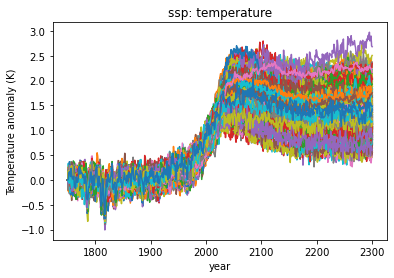

In [10]:
import matplotlib.pyplot as pl
pl.plot(model.timebounds, model.temperature.loc[dict(scenario="ssp119", layer=0)], label=model.configs);
pl.title('ssp: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

In [11]:
model.temperature.loc[dict(scenario="ssp119", layer=0)].shape

(551, 1001)

(551, 1001)


Text(0, 0.5, 'Temperature anomaly (K)')

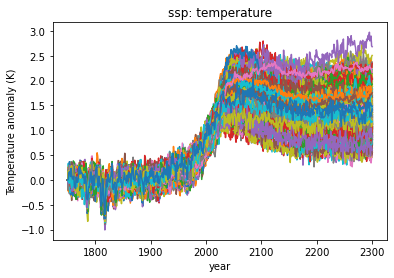

In [11]:
import matplotlib.pyplot as pl
temperature = model.get_temperature_array()



#Plot temp array of shape (551, 1001) where 551 is the number of years and 1001 is the number of ensembles
# Shape [timestep, scenario, ensemble, box/layer=0]
temp = temperature[:,0,:,0]
print(temp.shape)

#Shape: timepoints, scenarios and ensemblemodels
pl.plot(model.timebounds, temp, label=model.configs);
pl.title('ssp: temperature')
pl.xlabel('year')
pl.ylabel('Temperature anomaly (K)')

In [ ]:
#Extracting the temperature data

temp = model.temperature.loc[dict(scenario=fair_scenario, layer=0)]
temp.name = 'temperature'
temp_df = temp.to_dataframe().reset_index()


In [25]:
total_emis_test = emissions_array #[:,:,0]
#sum all the emissions of regions per timestep to get total emissions for each timestep
total_emis_test = np.sum(total_emis_test, axis=0)
#testdf = pd.DataFrame(emissions_array[:,:,0])


In [7]:

testdf = pd.DataFrame(model.emissions.sel(specie="CO2 FFI", scenario="ssp119"))

In [11]:
testdf2 = total_emissions[:,:,0]

In [8]:
testdf2 = emissions_array[:,:,0]

In [13]:
# Load pickle file

import pickle
with open('data/alpha_downscaler_coefficient.pickle', 'rb') as f:
    alpha = pickle.load(f)

#Reshape alpha from (57,1,1) to (57,1)
alpha = alpha.reshape(57,1)

# Import beta
with open('data/beta_downscaler_coefficient.pickle', 'rb') as f:
    beta = pickle.load(f)

#Reshape beta from (57,1,1) to (57,1)
beta = beta.reshape(57,1)

In [14]:
# Save Alpha and Beta as pickle and replace the old files
with open('data/alpha_downscaler_coefficient.pickle', 'wb') as f:
    pickle.dump(alpha, f)

with open('data/beta_downscaler_coefficient.pickle', 'wb') as f:
    pickle.dump(beta, f)



In [1]:
import pickle
with open('data/alpha_downscaler_coefficient.pickle', 'rb') as f:
    alpha = pickle.load(f)

# Import beta
with open('data/beta_downscaler_coefficient.pickle', 'rb') as f:
    beta = pickle.load(f)